### Strategy from 《Momentum and trend following trading strategies for currencies and bitcoin》

In [1]:
import get_data
import generate_signals
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 60
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
import itertools
import datetime
import result_analysis
from matplotlib.ticker import FormatStrFormatter

In [2]:
#define EMA lengths for the strategy
period=[8,16,32,24,48,96]

### G10 Currencies

##### Data Downloading

In [3]:
#select the symbols we use
G10_daily_category=['DEXUSAL','DEXCAUS','DEXSZUS','DEXUSUK','DEXJPUS','DEXNOUS','DEXUSNZ','DEXSDUS']

In [4]:
#stretching Data
G10_daily = get_data.currency()
print(G10_daily.get_all_symbols())
data_dict=G10_daily.get_currency(G10_daily_category)

Try to get your own key, though you can use my key:)

['DEXUSAL', 'DEXCAUS', 'DEXSZUS', 'DEXUSUK', 'DEXJPUS', 'DEXNOUS', 'DEXUSNZ', 'DEXSDUS', 'DTWEXM', 'DTWEXB', 'DEXUSEU', 'DEXCHUS', 'DEXMXUS', 'DEXBZUS', 'DEXKOUS', 'DEXINUS', 'DEXVZUS', 'DEXMAUS', 'DEXTHUS', 'DEXSFUSDEXTAUS', 'DEXHKUS', 'DEXSIUS', 'DEXSLUS']
The currency you are downloading are ['DEXUSAL', 'DEXCAUS', 'DEXSZUS', 'DEXUSUK', 'DEXJPUS', 'DEXNOUS', 'DEXUSNZ', 'DEXSDUS']


In [5]:
##Save data to file
#import pickle
#file = open('G10_currency', 'wb')
#pickle.dump(data_dict, file)
#file.close()

##### Data Cleaning

In [6]:
for i in range(len(G10_daily_category)):
    index=G10_daily_category[i]
    data_dict[index].value.fillna(method='pad',inplace=True)
    #del duplicate data
    dup=data_dict[index].duplicated('date')
    data_dict[index]=data_dict[index][~dup]
    #use USD as basic currency
    if i in [0,3,5,8]:
        data_dict[index].value=1/data_dict[index].value
#if date is all the same
for j,k in itertools.combinations(range(len(G10_daily_category)),2):
    if(sum(data_dict[G10_daily_category[j]].date!=\
              data_dict[G10_daily_category[k]].date)>0):
        print('Dates of dataset '+G10_daily_category[j]+' and '+\
              G10_daily_category[k]+' are different')
date=data_dict[list(data_dict.keys())[0]].date

##### Data Analysis

In [7]:
data_df=pd.DataFrame()
for i in range(len(G10_daily_category)):
    index=G10_daily_category[i]
    data_df[index]=data_dict[index].value
data_df.index=data_dict[index].date

In [8]:
data_df.columns=['AUD/USD','CAD/USD', 'CHF/USD', 'GBP/USD', 'JPY/USD', 'NOK/USD', 'NZD/USD', 'SEK/USD']

In [9]:
A_re_df=((data_df-data_df.shift(1))/data_df.shift(1)).dropna()

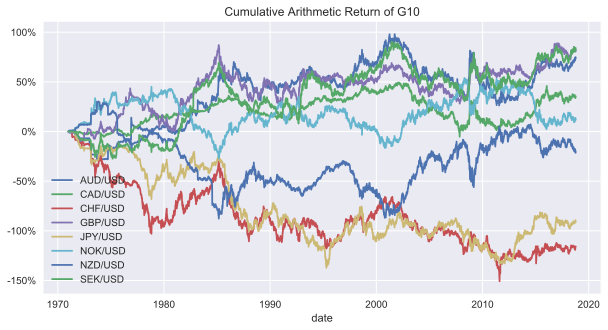

In [10]:
ax1=plt.subplot(111)
fmt='%.f%%'
ax1.yaxis.set_major_formatter(FormatStrFormatter(fmt))
A_re_cumsum=A_re_df.cumsum()*100
A_re_cumsum.plot(figsize=(10,5),ax=ax1)
plt.title('Cumulative Arithmetic Return of G10')
plt.savefig('./Cum_RE_G10.png')
plt.show()

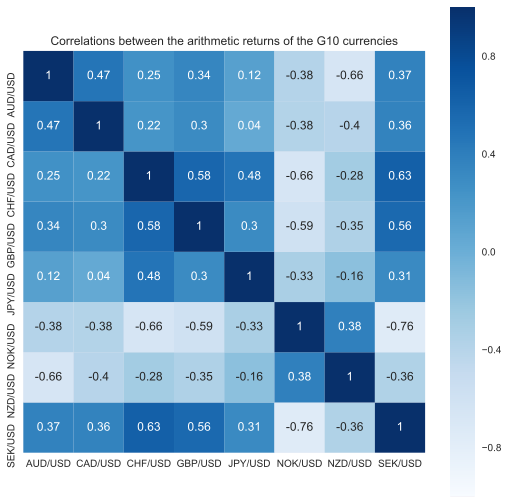

In [11]:
plt.subplots(figsize=(9, 9)) 
sns.heatmap(A_re_df.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlations between the arithmetic returns of the G10 currencies')
plt.savefig('./Corr_G10.png')
plt.show()

##### Generating Signal

In [12]:
signal_class=generate_signals.signal_1(data_dict,period)

In [13]:
signal_class.get_signal()

In [14]:
signal_df=signal_class.signal_df

In [15]:
price_df=pd.DataFrame()
for index in G10_daily_category:
    price_df[index]=data_dict[index].value
price_df.set_index(date,inplace=True)
price_df=price_df.loc[signal_df.index]

<strong>Time Series Portfolio</strong>

In [16]:
#TS
position=signal_df/8    
#weight=price_df.apply(lambda x:x/np.sum(x),axis=1)
return_matrix=(price_df-price_df.shift(1))/price_df.shift(1)
return_sep=position.shift(1)*return_matrix
return_sep=return_sep.dropna()
daily_re=return_sep.sum(axis=1)

In [17]:
re_a1=result_analysis.result_daily(daily_re)
re_a1.get_metrics()
print('Annualized Return: ',re_a1.ar)
print('Annualized SD: ',re_a1.std)
print('Annualized Sharp Ratio: ',re_a1.sp)
print('Maximum draw down: ',re_a1.mdd)

Annualized Return:  0.0392389775422
Annualized SD:  0.0430200170444
Annualized Sharp Ratio:  0.533485539079
Maximum draw down:  -0.474541505546


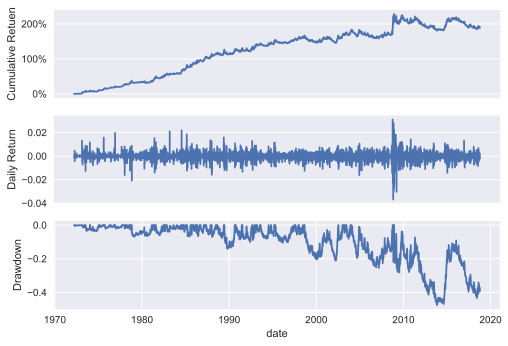

In [18]:
re_a1.figure_plot()

<strong>Cross-sectional Portfolio</strong>

In [19]:
signal_L3=signal_df.apply(lambda x: x.where(x<x.nlargest(3)[2],60),axis=1)
signal_S3=signal_L3.apply(lambda x: x.where(x>x.nsmallest(3)[2],-60),axis=1)
signal_else=signal_S3.apply(lambda x:x.where(np.abs(x)>1,0),axis=1)
position=signal_else/360

return_matrix=(price_df-price_df.shift(1))/price_df.shift(1)
return_sep=position.shift(1)*return_matrix
return_sep=return_sep.dropna()
daily_re=return_sep.sum(axis=1)
daily_cum_re=(daily_re+1).cumprod()-1

In [20]:
re_a2=result_analysis.result_daily(daily_re)
re_a2.get_metrics()
print('Annualized Return: ',re_a2.ar)
print('Annualized SD: ',re_a2.std)
print('Annualized Sharp Ratio: ',re_a2.sp)
print('Maximum draw down: ',re_a2.mdd)

Annualized Return:  0.0645357864515
Annualized SD:  0.0604928536052
Annualized Sharp Ratio:  0.514979049008
Maximum draw down:  -1.33474891703


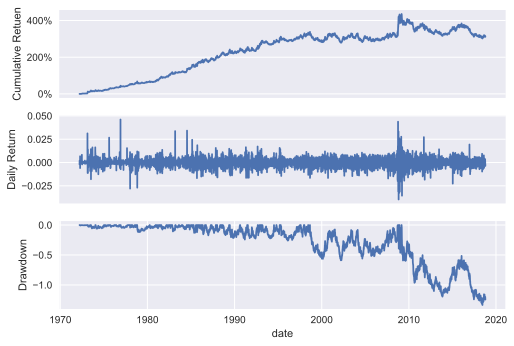

In [21]:
re_a2.figure_plot()

<h3>Emerging Market Currencies</h3>

##### Data Downloading

In [22]:
EMC_daily_category=['DEXMXUS','DEXBZUS','DEXKOUS','DEXINUS','DEXTHUS','DEXSFUS','DEXTAUS']

In [23]:
EMC_daily = get_data.currency()
data_dict=EMC_daily.get_currency(EMC_daily_category)

Try to get your own key, though you can use my key:)

The currency you are downloading are ['DEXMXUS', 'DEXBZUS', 'DEXKOUS', 'DEXINUS', 'DEXTHUS', 'DEXSFUS', 'DEXTAUS']


##### Data Cleaning

In [24]:
for i in data_dict.keys():
    print(i,len(data_dict[i]))
    print(data_dict[i].iloc[0,0],data_dict[i].iloc[-1,0])

DEXMXUS 6507
1993-11-08 00:00:00 2018-10-12 00:00:00
DEXBZUS 6208
1995-01-02 00:00:00 2018-10-12 00:00:00
DEXKOUS 9791
1981-04-13 00:00:00 2018-10-12 00:00:00
DEXINUS 11946
1973-01-02 00:00:00 2018-10-12 00:00:00
DEXTHUS 9862
1981-01-02 00:00:00 2018-10-12 00:00:00
DEXSFUS 15941
1971-01-04 00:00:00 2018-10-12 00:00:00
DEXTAUS 9149
1983-10-03 00:00:00 2018-10-12 00:00:00


In [25]:
start_date=data_dict['DEXBZUS'].iloc[0,0]

In [26]:
for i in data_dict.keys():
    data_dict[i]=data_dict[i][data_dict[i].date>start_date]

In [27]:
for i in range(len(EMC_daily_category)):
    index=EMC_daily_category[i]
    data_dict[index].value.fillna(method='pad',inplace=True)
    #del duplicate data
    dup=data_dict[index].duplicated('date')
    data_dict[index]=data_dict[index][~dup]
    data_dict[index].reset_index(drop=True,inplace=True)

In [28]:
#if date is all the same
for j,k in itertools.combinations(range(len(EMC_daily_category)),2):
    if(sum(data_dict[EMC_daily_category[j]].date!=\
              data_dict[EMC_daily_category[k]].date)>0):
        print('Dates of dataset '+EMC_daily_category[j]+' and '+\
              EMC_daily_category[k]+' are different')
date=data_dict[list(data_dict.keys())[0]].date

##### Data Analysis

In [29]:
data_df=pd.DataFrame()
for i in range(len(EMC_daily_category)):
    index=EMC_daily_category[i]
    data_df[index]=data_dict[index].value
data_df.index=data_dict[index].date

In [30]:
data_df.columns=['MXN/USD', 'BRL/USD', 'KRW/USD', 'INR/USD', 'THB/USD', 'ZAR/USD', 'TWD/USD']

In [31]:
A_re_df=((data_df-data_df.shift(1))/data_df.shift(1)).dropna()

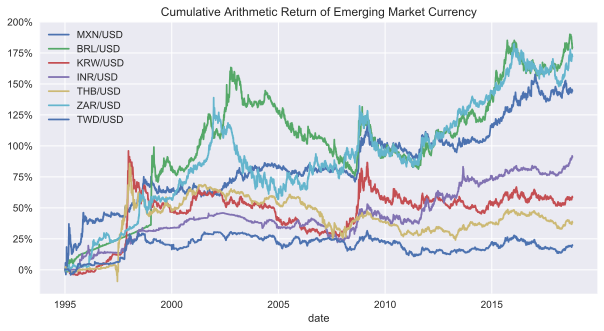

In [32]:
ax1=plt.subplot(111)
fmt='%.f%%'
ax1.yaxis.set_major_formatter(FormatStrFormatter(fmt))
A_re_cumsum=A_re_df.cumsum()*100
A_re_cumsum.plot(figsize=(10,5),ax=ax1)
plt.title('Cumulative Arithmetic Return of Emerging Market Currency')
plt.savefig('./Cum_RE_EMC.png')
plt.show()

In [33]:
A_re_cumsum.tail()

MXN/USD     BRL/USD    KRW/USD    INR/USD    THB/USD  \
date                                                                  
2018-10-08  144.734844  182.266272  58.506531  91.175107  38.451664   
2018-10-09  144.705918  178.432011  58.649735  91.947883  38.999943   
2018-10-10  145.053131  179.166202  59.182012  91.840255  38.757593   
2018-10-11  144.770030  179.158222  58.765820  91.557427  37.998406   
2018-10-12  144.260054  179.780711  58.471329  90.963154  38.243204   

               ZAR/USD    TWD/USD  
date                               
2018-10-08  173.915720  19.753308  
2018-10-09  172.686349  19.947420  
2018-10-10  172.396494  20.011999  
2018-10-11  172.464894  20.044267  
2018-10-12  172.157307  19.689429

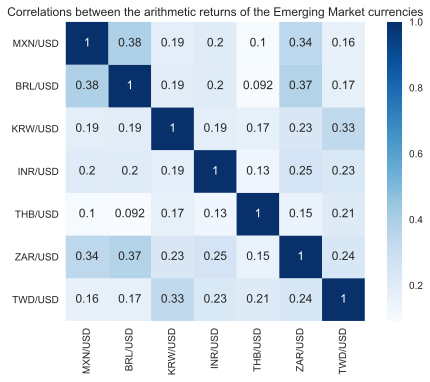

In [34]:
plt.subplots()
sns.heatmap(A_re_df.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlations between the arithmetic returns of the Emerging Market currencies')
plt.savefig('./Corr_EMC.png')
plt.show()

##### Sinal Generating

In [35]:
signal_class=generate_signals.signal_1(data_dict,period)

In [36]:
signal_class.get_signal()

In [37]:
signal_df=signal_class.signal_df

In [38]:
price_df=pd.DataFrame()
for index in EMC_daily_category:
    price_df[index]=data_dict[index].value
price_df.set_index(date,inplace=True)
price_df=price_df.loc[signal_df.index]

##### Time Series

In [39]:
#TS
position=signal_df/7    
#weight=price_df.apply(lambda x:x/np.sum(x),axis=1)
return_matrix=(price_df-price_df.shift(1))/price_df.shift(1)
return_sep=position.shift(1)*return_matrix
return_sep=return_sep.dropna()
daily_re=return_sep.sum(axis=1)

In [40]:
re_a3=result_analysis.result_daily(daily_re)
re_a3.get_metrics()
print('Annualized Return: ',re_a3.ar)
print('Annualized SD: ',re_a3.std)
print('Annualized Sharp Ratio: ',re_a3.sp)
print('Maximum draw down: ',re_a3.mdd)

Annualized Return:  0.0366400202431
Annualized SD:  0.0409902552132
Annualized Sharp Ratio:  0.666219562741
Maximum draw down:  -0.135173924298


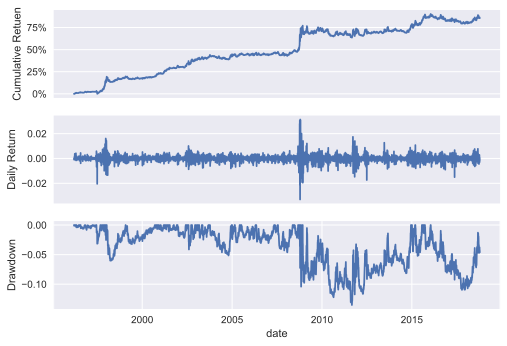

In [41]:
re_a3.figure_plot()

##### Cross sectional

In [42]:
signal_L3=signal_df.apply(lambda x: x.where(x<x.nlargest(3)[2],60),axis=1)
signal_S3=signal_L3.apply(lambda x: x.where(x>x.nsmallest(3)[2],-60),axis=1)
signal_else=signal_S3.apply(lambda x:x.where(np.abs(x)>1,0),axis=1)
position=signal_else/360

return_matrix=(price_df-price_df.shift(1))/price_df.shift(1)
return_sep=position.shift(1)*return_matrix
return_sep=return_sep.dropna()
daily_re=return_sep.sum(axis=1)
daily_cum_re=(daily_re+1).cumprod()-1

In [43]:
re_a4=result_analysis.result_daily(daily_re)
re_a4.get_metrics()
print('Annualized Return: ',re_a4.ar)
print('Annualized SD: ',re_a4.std)
print('Annualized Sharp Ratio: ',re_a4.sp)
print('Maximum draw down: ',re_a4.mdd)

Annualized Return:  0.0118696477029
Annualized SD:  0.0434737607769
Annualized Sharp Ratio:  0.262719216725
Maximum draw down:  -0.219670361427


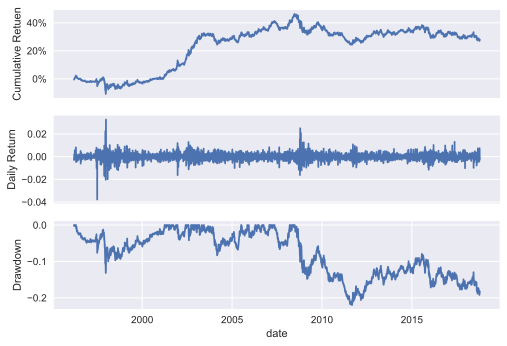

In [44]:
re_a4.figure_plot()

<h3>Cryptocurrency</h3>

##### Data Downloading

In [45]:
Crypto_daily_category=['BTC','DASH','DOGE','LTC','MAID','XMR','XRP']

In [46]:
Crypto_daily = get_data.cryptocurrency()
data_dict=Crypto_daily.daily_price_historical(Crypto_daily_category)

##### Data Cleaning

In [47]:
for i in data_dict.keys():
    print(i,len(data_dict[i]))
    print(data_dict[i].index[0],data_dict[i].index[-1])

BTC 3017
2010-07-16 2018-10-18
DASH 1715
2014-02-07 2018-10-18
DOGE 1722
2014-01-31 2018-10-18
LTC 1822
2013-10-23 2018-10-18
MAID 1360
2015-01-28 2018-10-18
XMR 1360
2015-01-28 2018-10-18
XRP 1368
2015-01-20 2018-10-18


In [48]:
start_date=data_dict['MAID'].index[0]

In [49]:
for i in data_dict.keys():
    data_dict[i]=data_dict[i][data_dict[i].index>=start_date]

In [50]:
for i in range(len(Crypto_daily_category)):
    index=Crypto_daily_category[i]
    data_dict[index]['date']=data_dict[index].index
    data_dict[index]['value']=data_dict[index].close
    data_dict[index].drop(['open','high','low','close'],axis=1,inplace=True)
    data_dict[index].reset_index(drop=True,inplace=True)

In [51]:
#if date is all the same
for j,k in itertools.combinations(range(len(Crypto_daily_category)),2):
    if(sum(data_dict[Crypto_daily_category[j]].date!=\
              data_dict[Crypto_daily_category[k]].date)>0):
        print('Dates of dataset '+Crypto_daily_category[j]+' and '+\
              Crypto_daily_category[k]+' are different')
date=data_dict[list(data_dict.keys())[0]].date

##### Data Analysis

In [52]:
data_df=pd.DataFrame()
for i in range(len(Crypto_daily_category)):
    index=Crypto_daily_category[i]
    data_df[index]=data_dict[index].value
data_df.index=data_dict[index].date

In [53]:
data_df.columns=['BTC/USD', 'DASH/USD', 'DOGE/USD','LTC/USD','MAID/USD', 'XMR/USD','XRP/USD']

In [54]:
A_re_df=((data_df-data_df.shift(1))/data_df.shift(1)).dropna()

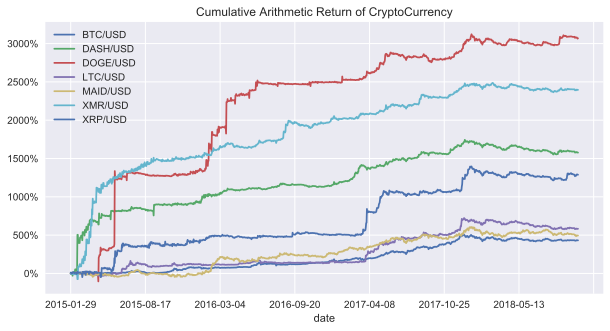

In [55]:
ax1=plt.subplot(111)
fmt='%.f%%'
ax1.yaxis.set_major_formatter(FormatStrFormatter(fmt))
A_re_cumsum=A_re_df.cumsum()*100
A_re_cumsum.plot(figsize=(10,5),ax=ax1)
plt.title('Cumulative Arithmetic Return of CryptoCurrency')

plt.savefig('./Cum_RE_Crypto.png')
plt.show()

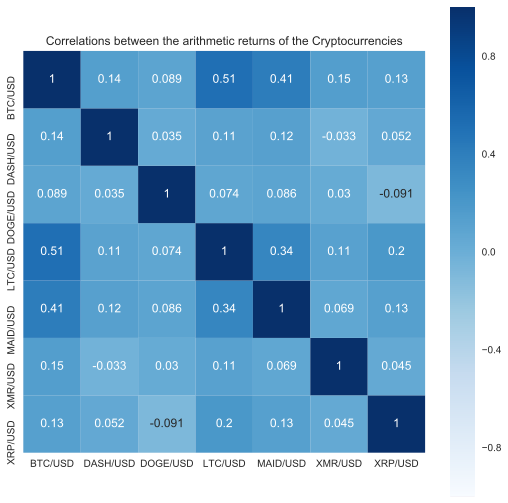

In [56]:
plt.subplots(figsize=(9, 9))
sns.heatmap(A_re_df.corr(), annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlations between the arithmetic returns of the Cryptocurrencies')
plt.savefig('./Corr_Crypto.png')
plt.show()

##### Sinal Generating

In [57]:
signal_class=generate_signals.signal_1(data_dict,period,365)

In [58]:
signal_class.get_signal()

In [59]:
signal_df=signal_class.signal_df

In [60]:
price_df=pd.DataFrame()
for index in Crypto_daily_category:
    price_df[index]=data_dict[index].value
price_df.set_index(date,inplace=True)
price_df=price_df.loc[signal_df.index]

##### Time Series

In [61]:
#TS
position=signal_df/7    
return_matrix=(price_df-price_df.shift(1))/price_df.shift(1)
return_sep=position.shift(1)*return_matrix
return_sep=return_sep.dropna()
daily_re=return_sep.sum(axis=1)

In [62]:
re_a5=result_analysis.result_daily(daily_re,365)
re_a5.get_metrics()
print('Annualized Return: ',re_a5.ar)
print('Annualized SD: ',re_a5.std)
print('Annualized Sharp Ratio: ',re_a5.sp)
print('Maximum draw down: ',re_a5.mdd)

Annualized Return:  2.97653555395
Annualized SD:  0.57791494889
Annualized Sharp Ratio:  1.77192664434
Maximum draw down:  -12.8354697478


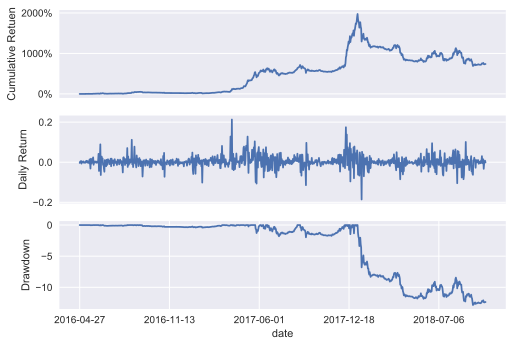

In [63]:
re_a5.figure_plot()

##### Cross Sectional

In [64]:
signal_L3=signal_df.apply(lambda x: x.where(x<x.nlargest(3)[2],60),axis=1)
signal_S3=signal_L3.apply(lambda x: x.where(x>x.nsmallest(3)[2],-60),axis=1)
signal_else=signal_S3.apply(lambda x:x.where(np.abs(x)>1,0),axis=1)
position=signal_else/360

return_matrix=(price_df-price_df.shift(1))/price_df.shift(1)
return_sep=position.shift(1)*return_matrix
return_sep=return_sep.dropna()
daily_re=return_sep.sum(axis=1)
daily_cum_re=(daily_re+1).cumprod()-1

In [65]:
re_a6=result_analysis.result_daily(daily_re,365)
re_a6.get_metrics()
print('Annualized Return: ',re_a6.ar)
print('Annualized SD: ',re_a6.std)
print('Annualized Sharp Ratio: ',re_a6.sp)
print('Maximum draw down: ',re_a6.mdd)

Annualized Return:  3.46241455079
Annualized SD:  0.541207694638
Annualized Sharp Ratio:  1.94709372341
Maximum draw down:  -3.50888560431


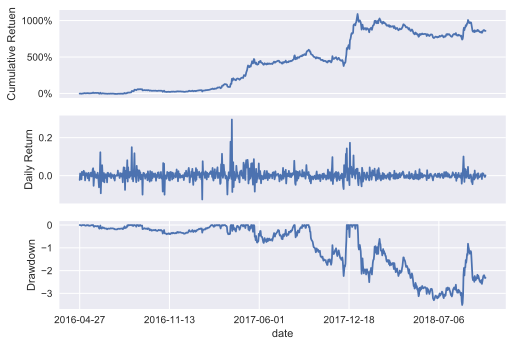

In [66]:
re_a6.figure_plot()